# ゲイン調節と四則演算

{cite:p}`Goldwyn2018-ug`を実装．神経演算 (neuronal arithmetic; {cite:p}`Angus_Silver2010-fd`)のモデル．

In [1]:
using Base: @kwdef
using Parameters: @unpack # or using UnPack
using PyPlot, ProgressMeter, Distributions
rc("axes.spines", top=false, right=false)

In [2]:
@kwdef struct HHIAParameter{FT}
    Cm::FT  = 1.0 # 膜容量(uF/cm^2)
    gNa::FT = 37.0 # Na+ の最大コンダクタンス(mS/cm^2)
    gK::FT  = 45.0 # K+ の最大コンダクタンス(mS/cm^2)
    gL::FT  =  1.0 # 漏れイオンの最大コンダクタンス(mS/cm^2)
    gA::FT  =  20.0
    ENa::FT = 55.0 # Na+ の平衡電位(mV)
    EK::FT = -80.0 # K+ の平衡電位(mV)
    EL::FT = -70.0 #漏れイオンの平衡電位(mV)
    gExc::FT = 0.5
    gInh::FT = 1.0
    VExc::FT = 0
    VInh::FT = -85.0
    βExc::FT = 0.2
    βInh::FT = 0.18
    tr::FT = 0.5 # ms
    td::FT = 8.0 # ms
    γ1::FT = 1/td
    γ2::FT = 1/tr - 1/td
    v0::FT = -20.0 # mV
end

@kwdef mutable struct HHIA{FT}
    param::HHIAParameter = HHIAParameter{FT}()
    N::Int
    v::Vector{FT} = fill(-70.0, N)
    n::Vector{FT} = fill(1.0/(1 + exp(-(-70.0 + 32)/8)), N)
    a::Vector{FT} = fill(1.0/(1 + exp(-(-70.0 + 50)/20)), N)
    b::Vector{FT} = fill(1.0/(1 + exp((-70.0 + 70)/6)), N)
    r::Vector{FT} = zeros(N)
    sExc::Vector{FT} = zeros(N)
    sInh::Vector{FT} = zeros(N)
end

In [3]:
function update!(variable::HHIA, param::HHIAParameter, spikesExc::Vector, spikesInh::Vector, dt)
    @unpack N, v, n, a, b, r, sExc, sInh = variable
    @unpack Cm, gNa, gK, gL, gA, ENa, EK, EL, gExc, gInh, VExc, VInh, βExc, βInh, γ1, γ2, v0 = param
    @inbounds for i = 1:N
        m, h = 1 / (1 + exp(-(v[i]+30)/15)), 1 - n[i]
        
        n[i] += dt * 0.75(1.0/(1 + exp(-0.125(v[i] + 32))) - n[i]) / (1 + 100 / (1 + exp((v[i] + 80)/26)))
        a[i] += dt * 0.5(1.0/(1 + exp(-0.05(v[i] + 50))) - a[i])
        b[i] += dt * (1.0/(1 + exp((v[i] + 70)/6)) - b[i]) / 150
        
        sExc[i] += -sExc[i] * βExc*dt + spikesExc[i]
        sInh[i] += -sInh[i] * βInh*dt + spikesInh[i]
        IExc = gExc * sExc[i] * (v[i] - VExc) 
        IInh = gInh * sInh[i] * (v[i] - VInh)

        IL = gL * (v[i] - EL)
        IK = gK * n[i]^4 * (v[i] - EK)
        IA = gA * a[i]^3 * b[i] * (v[i] - EK)
        INa = gNa * m^3 * h * (v[i] - ENa)
        
        v[i] += dt/Cm * -(IL + IK + IA + INa + IExc + IInh)
        r[i] += dt * (γ2 * (1.0 - r[i])/(1.0 + exp(-v[i] + v0)) - r[i] * γ1)
    end
end

update! (generic function with 1 method)

In [4]:
function GammaSpike(T, dt, n_neurons, fr, k)
    nt = Int(T/dt) # number of timesteps
    θ = 1/(k*(fr*dt*1e-3)) # fr = 1/(k*θ)

    isi = rand(Gamma(k, θ), Int(round(nt*1.5/fr)), n_neurons)
    spike_time = cumsum(isi, dims=1) # ISIを累積
    spike_time[spike_time .> nt - 1] .= 1 # ntを超える場合を1に
    spike_time = round.(Int, spike_time) # float to int
    spikes = zeros(Bool, nt, n_neurons) # スパイク記録変数

    for i=1:n_neurons    
        spikes[spike_time[:, i], i] .= 1
    end

    spikes[1] = 0 # (spike_time=1)の発火を削除
    return spikes
end

GammaSpike (generic function with 1 method)

In [5]:
function FIcurve(neurons, spikesExc, spikesInh, T=5000, dt=0.01f0)
    nt = Int(T/dt) # number of timesteps
    varr = zeros(Float32, nt,  neurons.N)
    
    @showprogress for t = 1:nt
        update!(neurons, neurons.param, spikesExc[t, :], spikesInh[t, :], dt)
        varr[t, :] = neurons.v
    end
    
    spike = (varr[1:nt-1, :] .< 0) .& (varr[2:nt, :] .> 0)
    output_spikes = sum(spike, dims=1) / T*1e3
    input_spikes = sum(spikesExc, dims=1) / T*1e3
    return input_spikes, output_spikes
end

FIcurve (generic function with 3 methods)

In [6]:
T, dt = 50000, 5e-2 # ms
nt = Int(T/dt)
N = 100
maxfrExc = 80; frInh = [0f0, 50f0]; 

In [7]:
function HHIAFIcurve_multi(gA, T, dt, N, maxfrExc, frInh)
    nInh = size(frInh)[1]
    input_spikes_arr, output_spikes_arr = zeros(nInh, N), zeros(nInh, N)
    nt = Int(T/dt) # number of timesteps
    frExc = rand(N) * maxfrExc
    spikesExc = zeros(Int, nt, N)
    for j = 1:N
        spikesExc[:, j] = rand(nt) .< frExc[j]*dt*1e-3
    end
    for i=1:nInh
        spikesInh = (frInh[i] == 0) ? zeros(Int, nt, N) : GammaSpike(T, dt, N, frInh[i], 12)    
        neurons = HHIA{Float32}(N=N, param=HHIAParameter{Float32}(gA=gA)) # modelの定義
        input_spikes_arr[i, :], output_spikes_arr[i, :] = FIcurve(neurons, spikesExc, spikesInh, T, dt)
    end
    return input_spikes_arr, output_spikes_arr
end

HHIAFIcurve_multi (generic function with 1 method)

In [8]:
input_spikes1, output_spikes1 = HHIAFIcurve_multi(20, T, dt, N, maxfrExc, frInh);
input_spikes2, output_spikes2 = HHIAFIcurve_multi(40, T, dt, N, maxfrExc, frInh);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:0939m39m39m39mm
Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09
Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


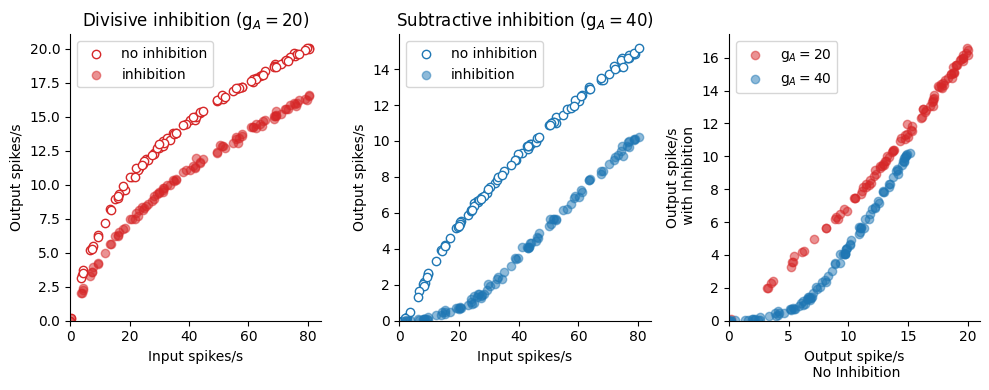

In [11]:
figure(figsize=(10, 4))
subplot(1,3,1); title(L"Divisive inhibition (g$_A=20$)")
scatter(input_spikes1[1, :], output_spikes1[1, :], facecolor="white", edgecolors="tab:red", label="no inhibition")
scatter(input_spikes1[2, :], output_spikes1[2, :], alpha=0.5, color="tab:red", label="inhibition")
xlim(0, ); ylim(0, ); xlabel("Input spikes/s"); ylabel("Output spikes/s"); legend()
subplot(1,3,2); title(L"Subtractive inhibition (g$_A=40$)")
scatter(input_spikes2[1, :], output_spikes2[1, :], facecolor="white", edgecolors="tab:blue", label="no inhibition")
scatter(input_spikes2[2, :], output_spikes2[2, :], alpha=0.5, color="tab:blue", label="inhibition")
xlim(0, ); ylim(0, ); xlabel("Input spikes/s"); ylabel("Output spikes/s"); legend()
subplot(1,3,3);
scatter(output_spikes1[1, :], output_spikes1[2, :], alpha=0.5, color="tab:red", label=L"g$_A=20$")
scatter(output_spikes2[1, :], output_spikes2[2, :], alpha=0.5, color="tab:blue", label=L"g$_A=40$")
xlim(0, ); ylim(0, ); xlabel("Output spike/s\n No Inhibition"); ylabel("Output spike/s\n with Inhibition"); legend()
tight_layout()

## 参考文献
```{bibliography}
:filter: docname in docnames
```